---
layout: post
date: 2016-03-19
title: Votes and Spending, Part 2&#58;</br>
    Spending through the ages
---




I [previously]({ post_url basic-vote-analysis-2015-01-13 }) found that at large democratic city council candidates who spend more money in the cycle prior to the primary generally receive a larger fraction of votes {% marginnote 'spending-exception' 'With the exception of one candidate who received a large fraction of votes though he claimed to have no expenditures. We will find similar occurrences in this analysis' %}. Here I extend the same analysis to two additional city council election cycles for which I could easily acquire data. I find a similar pattern particularly when standardized within year to account for campaign spending related inflation. Many regulatory changes occured over the time span of the analysis.
<!--more-->

## Voting data, 2007, 2011, and 2015
We begin with loading and combining the voting data. At the end of this section we'll have a list of the candidates grouped by election year with the number and percentage of votes they each got.

In [1]:
import pandas as pd
import numpy as np
import urllib2

vote_url_2015 = 'http://www.philadelphiavotes.com/files/raw-data/2015_primary.csv'
vote_stream_2015 = urllib2.urlopen(vote_url_2015)
primary_2015 = pd.read_csv(vote_stream_2015,sep=',')

vote_url_2011 = 'http://www.philadelphiavotes.com/files/raw-data/2011_primary.csv'
vote_stream_2011 = urllib2.urlopen(vote_url_2011)
primary_2011 = pd.read_csv(vote_stream_2011,sep=',')

vote_url_2007 = 'http://www.philadelphiavotes.com/files/raw-data/2007_primary.csv'
vote_stream_2007 = urllib2.urlopen(vote_url_2007)
primary_2007 = pd.read_csv(vote_stream_2007,sep=',')

First, I that the column names across the elections are the same. They differ in 2015, so I renamed the columns of that year to match the others. Then to each data frame I added a year column. I also checked the label for the At Large Democratic Council election and found it changed between 2007 and 2011.

In [3]:
primary_2015.rename(columns={'VOTE':'VOTES','CANDIDATE':'NAME'},inplace=True)
primary_2007['YEAR']=2007
primary_2011['YEAR']=2011
primary_2015['YEAR']=2015
office_str_2015 = 'COUNCIL AT LARGE-DEM'
office_str_2011 = 'COUNCIL AT LARGE-DEM'
office_str_2007 = 'COUNCIL AT LARGE-D'
primaries = pd.concat((primary_2007,primary_2011,primary_2015))

In [4]:
dem_council_primaries = primaries[primaries.OFFICE.isin([office_str_2007,office_str_2011])]
cgroup = dem_council_primaries.groupby(['YEAR','NAME'])
cgroup_sum = cgroup.sum()
cgroup_sum.drop(['WARD','DIVISION'],axis=1,inplace=True)
tot_votes = dem_council_primaries.groupby('YEAR').sum()['VOTES']
years = [2007,2011,2015]
vote_pcts = np.hstack([(cgroup_sum['VOTES'][year]/cgroup_sum['VOTES'][year].sum()).values for year in years])
cgroup_sum['VOTES_PCTS'] = vote_pcts

In [5]:
for year in years:
    print("Total number of votes in "+str(year)+": " +str(tot_votes[year]))

Total number of votes in 2007: 709720
Total number of votes in 2011: 477008
Total number of votes in 2015: 644038


With an incumbent mayor running for reelection in 2011, it's not too surprising to find a lower turnout. Next, let's collect and sort the finance data.

## Campaign finance data, 2007, 2011, and 2015

In [6]:
csv_dtype = {'EntityZip' : str,
             'EmployerZip': str}

data_url_2015 = 'ftp://ftp.phila-records.com/Year-to-Date%20Transaction%20Files/2015%20YTD/Explorer.Transactions.2015.YTD.txt'
data_stream_2015 = urllib2.urlopen(data_url_2015)
#Year to date (YTD)
finance_2015 = pd.read_csv(data_stream_2015,sep='\t',quotechar='"',
                      error_bad_lines=False, dtype=csv_dtype)


data_url_2011 = 'ftp://ftp.phila-records.com/Year-to-Date%20Transaction%20Files/2011%20YTD/Explorer.Transactions.2011.txt'
data_stream_2011 = urllib2.urlopen(data_url_2011)
#Year to date (YTD)
finance_2011 = pd.read_csv(data_stream_2011,sep='\t',quotechar='"',
                      error_bad_lines=False, dtype=csv_dtype)

data_url_2007 = 'ftp://ftp.phila-records.com/Year-to-Date%20Transaction%20Files/2007%20YTD/Explorer.Transactions.2007ytd.txt'
data_stream_2007 = urllib2.urlopen(data_url_2007)
#Year to date (YTD)
finance_2007 = pd.read_csv(data_stream_2007,sep='\t',quotechar='"',
                      error_bad_lines=False, dtype=csv_dtype)



As before, I need to remove amended lines to cut back on counting duplicated entries.

In [7]:
def filter_amends(df):
    """
    df is a ytd data frame including amended reports.
    This function filters out duplicate information in amendment stages and 
    keeps only the latest data.
    Pseudocode:
        -for each cycle check for each filer check if amended records
            -if filer in cycle had an amended record get most recent subdate:
                keep those lines
            -if filer had no amendments in cycle keep those lines
    returns a list of indices of lines in dataframe corresponding to latest
    filing data
    """
    indices_to_keep = np.array([],dtype='int64')
    cycles = df.Cycle.unique()
    for c in cycles:
        filers = df.loc[df.Cycle==c].FilerName.unique()
        dfc = df.loc[df.Cycle==c]
        for f in filers:
            dfcf = dfc.loc[dfc.FilerName==f]
            if np.sum(dfcf.Amended.str.contains('Y|y',na=False)):
                #print "amended: " + str(dfcf.SubDate.max())
                maxdate = dfcf.SubDate.max()
                #print 'amended: '+str(dfcf.loc[dfcf.SubDate == maxdate].index)
                indices_to_keep=np.append(indices_to_keep,dfcf.loc[dfcf.SubDate == maxdate].index)
            else:
                #print "not amended"
                indices_to_keep=np.append(indices_to_keep,dfcf.index)
    return indices_to_keep


finance_2015 = finance_2015.iloc[filter_amends(finance_2015)]
finance_2011 = finance_2011.iloc[filter_amends(finance_2011)]
finance_2007 = finance_2007.iloc[filter_amends(finance_2007)]

The finance data has matching columns for each year. As before, I use hand made tags based on unique values in the FilerName column and match those up to the candidate names from the voting data. This was a little tedious and is subject to the usual sorts of human error/inaccuracy. Even without those errors, the routing of money through PACs makes this especially difficult because it is hard to know from this data alone which candidate each PAC supported. For instance, an expense description of "media" or "consulting" or "GOTV" does not describe which candidate the PAC supported. Since I can not track down every political ad or GOTV worker, I restricted the tags to only committees and candidate names I can readily identify with a name on the ballot. {% marginnote 'more-problems' 'There are many other data problems too. Many PACs and candidates simply don't file. If they even get noticed, the fines are relatively small.' %}

In [8]:
tags_base = 'votes-analysis-p2-2015-01-19_files/'
tags_2015 = pd.read_csv(tags_base+'2015_dem_council_names.csv',sep=',')
tags_2015 = tags_2015[tags_2015.Party=='Dem'] #this tag file has extra info
tags_2011 = pd.read_csv(tags_base+'2011_dem_council_names.csv',sep=',')
tags_2007 = pd.read_csv(tags_base+'2007_dem_council_names.csv',sep=',')
dcc_finance_2015 = finance_2015[finance_2015.FilerName.isin(tags_2015.Filers.values)&(finance_2015.Cycle==3)]
dcc_finance_2011 = finance_2011[finance_2011.FilerName.isin(tags_2011.Filers.values)&(finance_2011.Cycle==3)]
dcc_finance_2007 = finance_2007[finance_2007.FilerName.isin(tags_2007.Filers.values)&(finance_2007.Cycle==3)]

The cell above selects out only the cycle 3 data for those candidates/tags. The below cell selects only the expenditures.

In [9]:
expenditures2015 = dcc_finance_2015[dcc_finance_2015.DocType.str.contains('Expenditures',na=False)]
expenditures2011 = dcc_finance_2011[dcc_finance_2011.DocType.str.contains('Expenditures',na=False)]
expenditures2007 = dcc_finance_2007[dcc_finance_2007.DocType.str.contains('Expenditures',na=False)]


In [10]:
print 'Total spending by Dem city council candidates cycle 3 2007: ' + \
        str(expenditures2007.Amount.sum())
print 'Total spending by Dem city council candidates cycle 3 2011: ' + \
        str(expenditures2011.Amount.sum())
print 'Total spending by Dem city council candidates cycle 3 2015: ' + \
        str(expenditures2015.Amount.sum())

Total spending by Dem city council candidates cycle 3 2007: 862083.07
Total spending by Dem city council candidates cycle 3 2011: 979575.49
Total spending by Dem city council candidates cycle 3 2015: 2675434.78


Interestingly, more money was spent in the 2011 election than the 2007 election though fewer votes were cast.

Below I create expenditure dataframes for each year with a new column that contains the name for that filer based on the corresponding name from the ballot.

In [11]:
def add_vote_name(x,tags):
    x['VotesName']=tags[0][tags[0].Filers.str.contains(x['FilerName'].values[0],na=False)].VotesName.values[0]
    return x
expenditures2015_vname = expenditures2015.groupby('FilerName').apply(add_vote_name, (tags_2015,))
expenditures2011_vname = expenditures2011.groupby('FilerName').apply(add_vote_name, (tags_2011,))
expenditures2007_vname = expenditures2007.groupby('FilerName').apply(add_vote_name, (tags_2007,))

In [12]:
dtsums_2015 = pd.DataFrame(expenditures2015_vname.groupby(['VotesName','DocType'])['Amount'].sum())
dtsums_2015['YEAR'] = 2015
dtsums_2011 = pd.DataFrame(expenditures2011_vname.groupby(['VotesName','DocType'])['Amount'].sum())
dtsums_2011['YEAR'] = 2011
dtsums_2007 = pd.DataFrame(expenditures2007_vname.groupby(['VotesName','DocType'])['Amount'].sum())
dtsums_2007['YEAR'] = 2007

The next cell is the big step of combining voter data and expenditure data. To the dataframe with voter percentages (`cgroup_sum`), I add the expenditure data. This is probably not the technically cleanest way to do this using Pandas.

In [13]:
dtsums = pd.concat((dtsums_2015,dtsums_2011,dtsums_2007))
newdtsum = dtsums.reset_index()
exlist_year = cgroup_sum.reset_index()
for year in years:
    for name in list(newdtsum[newdtsum.YEAR==year].VotesName):
        #if name in dtsums[:,'CFR - Schedule III - Statement of Expenditures']:
        exlist_year.loc[(cgroup_sum.reset_index().YEAR==year)&(cgroup_sum.reset_index().NAME==name),'Expense']=list(newdtsum.loc[(newdtsum.YEAR==year)&(newdtsum.VotesName==name)].Amount)[0]

In [14]:
exlist_year

,YEAR,NAME,VOTES,VOTES_PCTS,Expense
0,2007,ANDREW TOY,41654,0.058691,NaN
1,2007,BENJAMIN RAMOS,47343,0.066707,NaN
2,2007,BILL GREEN,62252,0.087713,310426.25
3,2007,BLONDELL REYNOLDS BROWN,51846,0.073051,46252.27
4,2007,CARYN HUNT,18723,0.026381,2424.00
5,2007,DEREK S GREEN,30745,0.043320,1633.88
6,2007,HARRY MASSELE,17102,0.024097,5548.00
7,2007,JAMES F KENNEY,95389,0.134404,60373.91
8,2007,JUAN F RAMOS,44205,0.062285,112865.97
9,2007,MACEO CUMMINGS,9577,0.013494,NaN


From this it appears many candidates either did not file their campaign finances for the 3rd cycle or they did not report any expenses during that cycle. I will address that at the end of this post again, but for now those entries will get dropped.

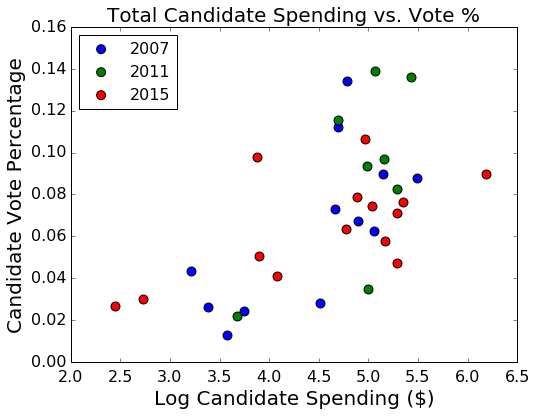

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(8,6))
for year,color in zip(years,['b','g','r']):
    plt.scatter(np.log10(exlist_year[exlist_year.YEAR==year].Expense),exlist_year[exlist_year.YEAR==year].VOTES_PCTS,s=80,c=color,label=str(year))
plt.ylim(0,0.16)
plt.legend(loc=2,scatterpoints=1,fontsize=16)
plt.title('Total Candidate Spending vs. Vote %',size=20)
plt.xlabel('Log Candidate Spending (\$)',size=20)
plt.ylabel('Candidate Vote Percentage',size=20)
plt.tick_params(axis='x', pad=8)
plt.tick_params(axis='both', which='major', labelsize=16)

There's a trend already, however to really compare data across years we can standardize the data within each year to get z scores.

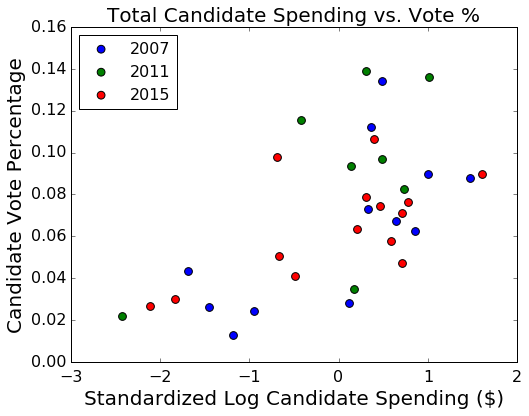

In [18]:
from sklearn import preprocessing
plt.figure(figsize=(8,6))
for year,color in zip(years,['b','g','r']):
    x = preprocessing.scale(np.log10(exlist_year[(exlist_year.YEAR==year)&np.isfinite(exlist_year.Expense)].Expense))
    plt.scatter(x,exlist_year[(exlist_year.YEAR==year)&np.isfinite(exlist_year.Expense)].VOTES_PCTS,c=color,label=str(year),s=60)
plt.ylim(0,0.16)
plt.legend(loc=2,scatterpoints=1,fontsize=16)
plt.title('Total Candidate Spending vs. Vote %',size=20)
plt.xlabel('Standardized Log Candidate Spending (\$)',size=20)
plt.ylabel('Candidate Vote Percentage',size=20)
plt.tick_params(axis='x', pad=8)
plt.tick_params(axis='both', which='major', labelsize=16)

In [23]:
print '        |  scaled fit [m, b]     |   raw fit [m, b]:'
for year in years:
    x = preprocessing.scale(np.log10(exlist_year[(exlist_year.YEAR==year)&np.isfinite(exlist_year.Expense)].Expense))
    x2 = np.log10(exlist_year[(exlist_year.YEAR==year)&np.isfinite(exlist_year.Expense)].Expense)
    print str(year)+ '    ' + \
        str(np.polyfit(x,exlist_year[(exlist_year.YEAR==year)&np.isfinite(exlist_year.Expense)].VOTES_PCTS,1)) + \
        str(np.polyfit(x2,exlist_year[(exlist_year.YEAR==year)&np.isfinite(exlist_year.Expense)].VOTES_PCTS,1))

        |  scaled fit [m, b]     |   raw fit [m, b]:
2007    [ 0.02491769  0.06346129][ 0.03445275 -0.08916387]
2011    [ 0.02566051  0.09013895][ 0.05030968 -0.1570854 ]
2015    [ 0.01458749  0.06504785][ 0.0144761 -0.0011184]


Scaling the data brings the fits more into line with eachother across years. Interestingly, the returns to spending seem to be lowest this past year when overall spending grew by so much. Furthermore, a more complete model would encapsulate the fact that the sum of all candidate votes fraction must be 1.

Finally, as mentioned before. Many candidates seem to not have listed any expenditures or even filed for the cycle. If we include their voter returns on the plots above by putting their percentages on the left y axis, then the model is clearly broken.

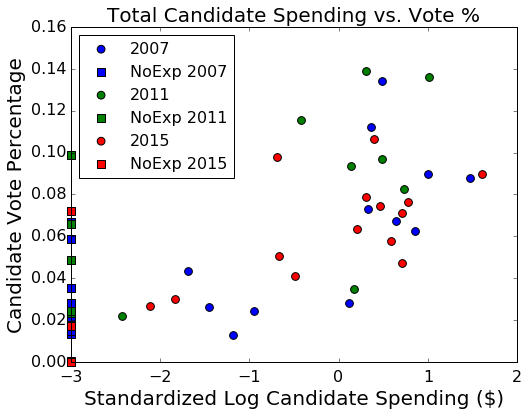

In [31]:
plt.figure(figsize=(8,6))
for year,color in zip(years,['b','g','r']):
    x = preprocessing.scale(np.log10(exlist_year[(exlist_year.YEAR==year)&np.isfinite(exlist_year.Expense)].Expense))
    plt.scatter(x,exlist_year[(exlist_year.YEAR==year)&np.isfinite(exlist_year.Expense)].VOTES_PCTS,c=color,label=str(year),s=60)
    plt.scatter(-3*np.ones(exlist_year[(exlist_year.YEAR==year)&np.isnan(exlist_year.Expense)].shape[0]),
                exlist_year[(exlist_year.YEAR==year)&np.isnan(exlist_year.Expense)].VOTES_PCTS,
                marker='s',c=color,label='NoExp '+str(year),s=60,clip_on=False)
plt.ylim(0,0.16)
plt.xlim(-3,2)
plt.legend(loc=2,scatterpoints=1,fontsize=16)
plt.title('Total Candidate Spending vs. Vote %',size=20)
plt.xlabel('Standardized Log Candidate Spending (\$)',size=20)
plt.ylabel('Candidate Vote Percentage',size=20)
plt.tick_params(axis='x', pad=8)
plt.tick_params(axis='both', which='major', labelsize=16)